<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

Author: [Yury Kashnitskiy](https://yorko.github.io). Translated and edited by [Christina Butsko](https://www.linkedin.com/in/christinabutsko/), [Nerses Bagiyan](https://www.linkedin.com/in/nersesbagiyan/), [Yulia Klimushina](https://www.linkedin.com/in/yuliya-klimushina-7168a9139), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center>Topic 4. Linear Classification and Regression
## <center> Part 4. Where Logistic Regression Is Good and Where It's Not

### Analysis of IMDB movie reviews

Now for a little practice! We want to solve the problem of binary classification of IMDB movie reviews. We have a training set with marked reviews, 12500 reviews marked as good, another 12500 bad. Here, it's not easy to get started with machine learning right away because we don't have the matrix $X$; we need to prepare it. We will use a simple approach: bag of words model. Features of the review will be represented by indicators of the presence of each word from the whole corpus in this review. The corpus is the set of all user reviews. The idea is illustrated by a picture

<img src="../../img/bag_of_words.svg" width=80% />

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

**To get started, we automatically download the dataset from [here](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) and unarchive it along with the rest of datasets in the data folder. The dataset is briefly described [here](http://ai.stanford.edu/~amaas/data/sentiment/). There are 12.5k of good and bad reviews in the test and training sets.**

In [4]:
from io import BytesIO
#https://docs.python.org/3/library/io.html
import requests
import tarfile

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

def load_imdb_dataset(extract_path="../../data", overwrite=False):
    #check if existed already
    if os.path.isfile(os.path.join(extract_path, "aclImdb", "README")) and not overwrite:
        #os.path.join: Join one or more path components intelligently. The return value is the concatenation of path and 
        #any members of *paths with exactly one directory separator (os.sep) following each non-empty part 
        #except the last, meaning that the result will only end in a separator if the last part is empty. 
        #If a component is an absolute path, all previous components are thrown away and joining continues 
        #from the absolute path component.
          #path = os.path.join('home', 'foo', 'work')
          #print(path)  # home/foo/work
        #os.path.isfile(path) Return True if path is an existing regular file.
        #https://docs.python.org/3/library/os.path.html#os.path.normpath
      
        print("IMDB dataset is already in place.")
        return
    
    print("Downloading the dataset from:  ", url)
    response = requests.get(url)
    #The requests library is the de facto standard for making HTTP requests in Python. 
    #http://docs.python-requests.org/en/master/user/quickstart/
    #https://realpython.com/python-requests/
    
    tar = tarfile.open(mode= "r:gz", fileobj = BytesIO(response.content))
    #The tarfile module makes it possible to read and write tar archives, including those using gzip, bz2 and 
    #lzma compression. 
    #'r:gz'	Open for reading with gzip compression.
    #https://docs.python.org/3/library/tarfile.html#tarfile.TarFile
    data = tar.extractall(extract_path)
    
load_imdb_dataset()

IMDB dataset is already in place.


In [5]:
#change if you have it in alternative location
PATH_TO_IMDB = "../../data/aclImdb"

reviews_train = load_files(os.path.join(PATH_TO_IMDB, "train"),
                           categories=['pos', 'neg'])
#categories : A collection of strings or None, optional (default=None).
#If None (default), load all the categories. If not None, list of category names to load (other categories ignored).
text_train, y_train = reviews_train.data, reviews_train.target

reviews_test = load_files(os.path.join(PATH_TO_IMDB, "test"),
                          categories=['pos', 'neg'])
text_test, y_test = reviews_test.data, reviews_test.target

In [6]:
# # Alternatively, load data from previously pickled objects. 
# import pickle
# with open('../../data/imdb_text_train.pkl', 'rb') as f:
#     text_train = pickle.load(f)
# with open('../../data/imdb_text_test.pkl', 'rb') as f:
#     text_test = pickle.load(f)
# with open('../../data/imdb_target_train.pkl', 'rb') as f:
#     y_train = pickle.load(f)
# with open('../../data/imdb_target_test.pkl', 'rb') as f:
#     y_test = pickle.load(f)

In [7]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))
#Count number of occurrences of each value in array of non-negative ints.
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in training data: 25000
[12500 12500]
Number of documents in test data: 25000
[12500 12500]


**Here are a few examples of the reviews.**

In [8]:
print(text_train[1])

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [9]:
y_train[1] # bad review

0

In [10]:
text_train[2]

b'Everyone plays their part pretty well in this "little nice movie". Belushi gets the chance to live part of his life differently, but ends up realizing that what he had was going to be just as good or maybe even better. The movie shows us that we ought to take advantage of the opportunities we have, not the ones we do not or cannot have. If U can get this movie on video for around $10, it\xc2\xb4d be an investment!'

In [11]:
y_train[2] # good review

1

In [12]:
# import pickle
# with open('../../data/imdb_text_train.pkl', 'wb') as f:
#     pickle.dump(text_train, f)
# with open('../../data/imdb_text_test.pkl', 'wb') as f:
#     pickle.dump(text_test, f)
# with open('../../data/imdb_target_train.pkl', 'wb') as f:
#     pickle.dump(y_train, f)
# with open('../../data/imdb_target_test.pkl', 'wb') as f:
#     pickle.dump(y_test, f)

## A Simple Count of Words

**First, we will create a dictionary of all the words using CountVectorizer**

In [13]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

**If you look at the examples of "words" (let's call them tokens), you can see that we have omitted many of the important steps in text processing (automatic text processing can itself be a completely separate series of articles).**

In [14]:
print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m']
['pincher', 'pinchers', 'pinches', 'pinching', 'pinchot', 'pinciotti', 'pine', 'pineal', 'pineapple', 'pineapples', 'pines', 'pinet', 'pinetrees', 'pineyro', 'pinfall', 'pinfold', 'ping', 'pingo', 'pinhead', 'pinheads', 'pinho', 'pining', 'pinjar', 'pink', 'pinkerton', 'pinkett', 'pinkie', 'pinkins', 'pinkish', 'pinko', 'pinks', 'pinku', 'pinkus', 'pinky', 'pinnacle', 'pinnacles', 'pinned', 'pinning', 'pinnings', 'pinnochio', 'pinnocioesque', 'pino', 'pinocchio', 'pinochet', 'pinochets', 'pinoy', 'pinpoint', 'pinpoints', 'pins', 'pinsent']


**Secondly, we are encoding the sentences from the training set texts with the indices of incoming words. We'll use the sparse format.**

In [15]:
X_train=cv.transform(text_train)
#Convert a collection of text documents to a matrix of token counts
#print(X_train)
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.transform

***
<font size=4>Count Vectorization (One-Hot Encoding)</font>

How does the Count Vectorization works?

We will be creating vectors that have a *dimensionality equal to the size of our vocabulary*, and if the text data features that vocab word, we will put a one in that dimension. Every time we encounter that word again, we will increase the count, leaving 0s everywhere we did not find the word even once.

For example, suppose that we have two setences: 
- "One of the most basic ways we can numerically represent words " "is through the one-hot encoding method (also sometimes called " "count vectorizing)."
- "One of the most"
where the first sentence has been brorken into several different pieces by space. 

Then we first train this set of sentences and we can look at this matrix (pattern)

In [26]:
sample_text = ["One of the most basic ways we can numerically represent words "
               "is through the one-hot encoding method (also sometimes called "
               "count vectorizing).",'One of the most']
cv.fit(sample_text)
vector = cv.transform(sample_text)
print('Vocabulary: ')
print(cv.vocabulary_)

Vocabulary: 
{'one': 12, 'of': 11, 'the': 15, 'most': 9, 'basic': 1, 'ways': 18, 'we': 19, 'can': 3, 'numerically': 10, 'represent': 13, 'words': 20, 'is': 7, 'through': 16, 'hot': 6, 'encoding': 5, 'method': 8, 'also': 0, 'sometimes': 14, 'called': 2, 'count': 4, 'vectorizing': 17}


First we have the dictionary of each word in this sentence set. System automatically attribute an index to each letter based on the alphabetical order. We have 20 words in total "also" start with a, so it comes with index 0.

In [27]:
print('Full vector: ')
print(vector)
print(vector.toarray())

Full vector: 
  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	2
  (0, 13)	1
  (0, 14)	1
  (0, 15)	2
  (0, 16)	1
  (0, 17)	1
  (0, 18)	1
  (0, 19)	1
  (0, 20)	1
  (1, 9)	1
  (1, 11)	1
  (1, 12)	1
  (1, 15)	1
[[1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0]]


Now We also both the raw matrix and the array formated matrix. If you look at the array matrix, every number inside shows the occurance of each word. **<font size=3, color='red'>The interesting thing here is every occurance number represent the "postion" of that letter in the whole vocabulary</font>**. Suppose now we just want to look at the position index of each letter of the first sentence, what are them?

In [2]:
print(vector[1].nonzero())

NameError: name 'vector' is not defined

Numpy.nonzero( )function is used to compute the indices of the elements that are non-zero ([reference](https://www.geeksforgeeks.org/numpy-nonzero-in-python/)). For example, consider the following code:

In [23]:
import numpy as geek 
arr = geek.array([[0, 8, 0], [7, 0, 0], [-5, 0, 1]]) 
  
print ("Input  array : \n", arr) 
    
out_tpl = geek.nonzero(arr) 
print ("Indices of non zero elements : ", out_tpl) 

Input  array : 
 [[ 0  8  0]
 [ 7  0  0]
 [-5  0  1]]
Indices of non zero elements :  (array([0, 1, 2, 2]), array([1, 0, 0, 2]))


That is first we ignore the 0 terms. Next start from 8, 8 is in the first conponent, so the "row index" should be 0. 7 in the second component, then its "row index" is 1....

Now we look at the "column" index, 8 is the second number in the first set so "column" index is 1. 7 is the first number in the second set so "column" index is 0. 

Based on the above 2 indices, <font size =3, color='blue'>(0, 1) $\Longleftrightarrow$ 8 and (1, 0) $\Longleftrightarrow$ 7.</font>

Now back to our example, since the letter in the array (CV) matrix is orderd alphabetically,<font size =3, color='red'> the "column index" is actally the Vocalbulary index of that letter, the "row" index has the same meaning, that is the index of the sentences in the whole dataset</font>. That is <font size =3, color='blue'>(0, 0) $\Longleftrightarrow$ "also" and (1, 9) $\Longleftrightarrow$ "most"</font>. If we look at the occurance, there are two words repeated twice here, first is <font size =3, color='blue'>(0, 12) $\Longleftrightarrow$ "one" and (0, 15) $\Longleftrightarrow$ "the"</font>. 

**Every combination of the row and column index gives the combination of the setence position and word's vocabulary index** ([reference: Hunter Heidenreich's blog](https://towardsdatascience.com/natural-language-processing-count-vectorization-with-scikit-learn-e7804269bb5e)). 

**Let's see how our transformation worked**

In [44]:
print(text_train[19726])

b'This movie is terrible but it has some good effects.'


In [45]:
X_train[19726].nonzero()[1]

array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
       66562], dtype=int32)

In [46]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
        66562], dtype=int32))

When we fix ourself at row 19726, this is the only row we have, so the row index will be all 0, but the "column" index tells us about the Vocabulary index of the words as usual.

In [47]:
print(X_train.shape[0])
print(X_train.shape[1])

25000
74849


That is we have 25000 reviews and 74849 unrepeated words.

**Third, we will apply the same operations to the test set**

In [48]:
X_test = cv.transform(text_test)

**The next step is to train Logistic Regression.**

In [49]:
%%time
logit = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=7)
#solver : str, {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default: ‘liblinear’.
#Algorithm to use in the optimization problem.

#For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
#For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is
#limited to one-versus-rest schemes.
#‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas ‘liblinear’ and ‘saga’ handle L1 penalty.
#Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. 
#You can preprocess the data with a scaler from sklearn.preprocessing.
logit.fit(X_train, y_train)

CPU times: user 536 ms, sys: 190 ms, total: 726 ms
Wall time: 4.03 s


**Let's look at accuracy on the both the training and the test sets.**

In [50]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3)
Returns the mean accuracy on the given test data and labels.

SyntaxError: invalid syntax (<ipython-input-50-64f49e762789>, line 2)

**The coefficients of the model can be beautifully displayed.**

In [63]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    #return the smallest and largest 25 cofficients respectively.
    #e.g.l=range(0,10) for n in l[-5:]: print(n), we got [5, 6 ,7 , 8, 9]
    #Returns the indices that would sort an array.
    #https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
    #thus here we have the indexs of the largest and smallest coefs not coefs themselves
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    #Stack arrays in sequence horizontally (column wise).
    #https://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html
    
    print(coef[interesting_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    #if we use interesting_coefficients instead of coef[interesting_coefficients], we will have only one color 
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");
        #corresponding fearture names for coefs


In [62]:
#Aside
#1. Largest values in a list 
l=range(0,10)
for n in l[-5:]:
  print('largest #s:%d' %n)

#2. argsort
x = np.array([3, 1, 2])
print("argsort:")
print(np.argsort(x))



largest #s:5
largest #s:6
largest #s:7
largest #s:8
largest #s:9
argsort:
[1 2 0]


In [51]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();
    

[-2.83101097 -2.55840603 -2.32697039 -2.04527086 -1.96313703 -1.94132675
 -1.76016164 -1.75293671 -1.72607482 -1.65594536 -1.60969851 -1.55867088
 -1.54748621 -1.5019982  -1.47484938 -1.4658655  -1.45113132 -1.44446619
 -1.41544392 -1.39509639 -1.37938571 -1.36118903 -1.35700953 -1.32419881
 -1.30743168  1.03997808  1.05186445  1.06786246  1.07200296  1.07298568
  1.09501504  1.09828892  1.10573093  1.11069192  1.12676075  1.15511772
  1.17293595  1.19267898  1.19478038  1.24779276  1.25275462  1.26858759
  1.29983016  1.35468352  1.53375637  1.54856533  1.57662463  1.64627987
  1.65663943  1.6758828 ]


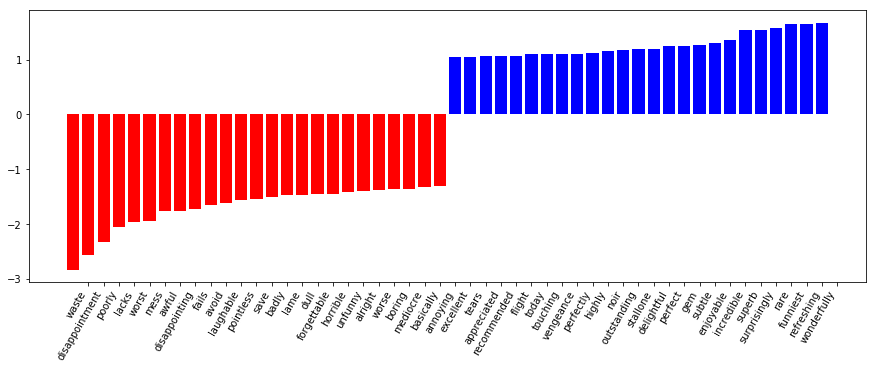

In [64]:
visualize_coefficients(logit, cv.get_feature_names())

**To make our model better, we can optimize the regularization coefficient for the `Logistic Regression`. We'll use `sklearn.pipeline` because `CountVectorizer` should only be applied to the training data (so as to not "peek" into the test set and not count word frequencies there). In this case, `pipeline` determines the correct sequence of actions: apply `CountVectorizer`, then train `Logistic Regression`.**

Previously, we have the type of the data that don't need to be Count Vectorized, but now we want to do 2 things at the same time: Count Vectorization and Logistic regression, so we need to build a new pipeline to combine/chain the two tasks together. ([What is pipeline?](https://medium.com/@yanhann10/a-brief-view-of-machine-learning-pipeline-in-python-5f50b941fca8)) 

**In this new pipeline, we apply CountVectorizer, then train Logistic Regression.**

In [23]:
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(CountVectorizer(),
                                # for some reason n_jobs > 1 won't work 
                                # with GridSearchCV's n_jobs > 1
                                LogisticRegression(solver='lbfgs', 
                                                   n_jobs=1,
                                                   random_state=7))

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.86396
CPU times: user 19.7 s, sys: 6.57 s, total: 26.3 s
Wall time: 9.26 s


However, we also want to know the best <font color='blue'>panelty term coefficient <i>C</i></font> and the <font color='blue'>best cross validation results</font>.

In [24]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, 
                          param_grid_logit, 
                          return_train_score=True, 
                          cv=3, n_jobs=-1)

grid_logit.fit(text_train, y_train)

CPU times: user 17.3 s, sys: 6.6 s, total: 23.9 s
Wall time: 39.5 s


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


**Let's print best $C$ and cv-score using this hyperparameter:**

In [25]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.1}, 0.8848)

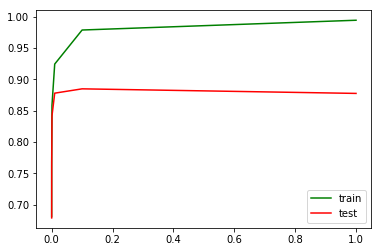

In [26]:
plot_grid_scores(grid_logit, 'logisticregression__C')

For the validation set:

In [27]:
grid_logit.score(text_test, y_test)

0.87812

The difference between the logit.score and logit.best_score is that **<font size=3, color='red'>logit.score returns the mean accuracy on the given test data and labels, while logit.best_score returns the Mean cross-validated score of the best_estimator</font>**.

**Now let's do the same with random forest. We see that, with logistic regression, we achieve better accuracy with less effort.**

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
forest = RandomForestClassifier(n_estimators=200, 
                                n_jobs=-1, random_state=17)

In [30]:
%%time
forest.fit(X_train, y_train)

CPU times: user 1min 27s, sys: 77.3 ms, total: 1min 27s
Wall time: 16.4 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [31]:
round(forest.score(X_test, y_test), 3)

0.855

### XOR-Problem
Let's now consider an example where linear models are worse.

Linear classification methods still define a very simple separating surface - a hyperplane. The most famous toy example of where classes cannot be divided by a hyperplane (or line) with no errors is "the XOR problem". An XOr function should return a true value if the two inputs are not equal and a false value if they are equal. All possible inputs and predicted outputs are shown in figure 1.

XOR is the "exclusive OR", a Boolean function with the following truth table:



<img src='../../img/XOR_table.gif'>

XOR is the name given to a simple binary classification problem in which the classes are presented as diagonally extended intersecting point clouds.
([More about XOR](https://medium.com/@jayeshbahire/the-xor-problem-in-neural-networks-50006411840b))
([More abour XOR2: cs231n](https://www.youtube.com/watch?v=OoUX-nOEjG0&list=PLC1qU-LWwrF64f4QKQT-Vg5Wr4qEE1Zxk&index=2)) [cs244n](http://cs224d.stanford.edu/lecture_notes/notes1.pdf)

In [32]:
# creating dataset
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

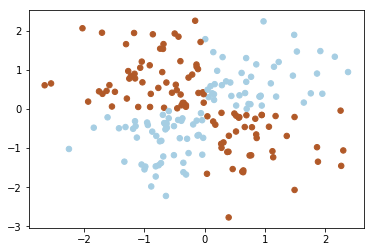

In [33]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired);

Obviously, one cannot draw a single straight line to separate one class from another without errors. Therefore, logistic regression performs poorly with this task.

In [34]:
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
    clf.fit(X, y)
    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                               linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);

/opt/conda/lib/python3.6/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/opt/conda/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'linetypes'
  s)


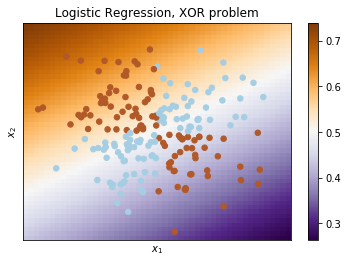

In [35]:
plot_boundary(LogisticRegression(solver='lbfgs'), X, y,
              "Logistic Regression, XOR problem")

But if one were to give polynomial features as an input (here, up to 2 degrees), then the problem is solved.

In [36]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [37]:
logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                       ('logit', LogisticRegression(solver='lbfgs' ))])

/opt/conda/lib/python3.6/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/opt/conda/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'linetypes'
  s)


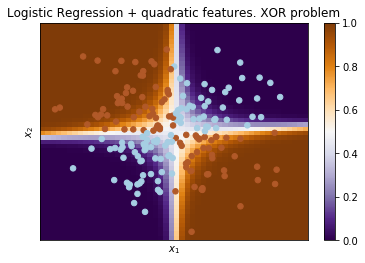

In [38]:
plot_boundary(logit_pipe, X, y,
              "Logistic Regression + quadratic features. XOR problem")

Here, logistic regression has still produced a hyperplane but in a 6-dimensional feature space $1, x_1, x_2, x_1^2, x_1x_2$ and $x_2^2$. When we project to the original feature space, $x_1, x_2$, the boundary is nonlinear.

In practice, polynomial features do help, but it is computationally inefficient to build them explicitly. SVM with the kernel trick works much faster. In this approach, only the distance between the objects (defined by the kernel function) in a high dimensional space is computed, and there is no need to produce a combinatorially large number of features. 

### Useful resources
- Main course [site](https://mlcourse.ai), [course repo](https://github.com/Yorko/mlcourse.ai), and YouTube [channel](https://www.youtube.com/watch?v=QKTuw4PNOsU&list=PLVlY_7IJCMJeRfZ68eVfEcu-UcN9BbwiX)
- Medium ["story"](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-4-linear-classification-and-regression-44a41b9b5220) based on this notebook
- Course materials as a [Kaggle Dataset](https://www.kaggle.com/kashnitsky/mlcourse)
- If you read Russian: an [article](https://habrahabr.ru/company/ods/blog/323890/) on Habrahabr with ~ the same material. And a [lecture](https://youtu.be/oTXGQ-_oqvI) on YouTube
- A nice and concise overview of linear models is given in the book [“Deep Learning”](http://www.deeplearningbook.org) (I. Goodfellow, Y. Bengio, and A. Courville).
- Linear models are covered practically in every ML book. We recommend “Pattern Recognition and Machine Learning” (C. Bishop) and “Machine Learning: A Probabilistic Perspective” (K. Murphy).
- If you prefer a thorough overview of linear model from a statistician’s viewpoint, then look at “The elements of statistical learning” (T. Hastie, R. Tibshirani, and J. Friedman).
- The book “Machine Learning in Action” (P. Harrington) will walk you through implementations of classic ML algorithms in pure Python.
- [Scikit-learn](http://scikit-learn.org/stable/documentation.html) library. These guys work hard on writing really clear documentation.
- Scipy 2017 [scikit-learn tutorial](https://github.com/amueller/scipy-2017-sklearn) by Alex Gramfort and Andreas Mueller.
- One more [ML course](https://github.com/diefimov/MTH594_MachineLearning) with very good materials.
- [Implementations](https://github.com/rushter/MLAlgorithms) of many ML algorithms. Search for linear regression and logistic regression.